In [1]:
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import uniform,norm,t,binom,expon,chi2,gamma,poisson,beta,dirichlet
from scipy.stats import multivariate_normal as multi_norm
from scipy.optimize import brentq
from scipy.special import perm,comb
import time
import pandas as pd

**8.1**

In [2]:
def increasing(theta):
    f=lambda x: x**theta
    X=uniform.rvs(size=10000)
    print(np.corrcoef(f(X),f(1-X))[0,1])

In [3]:
increasing(1)
increasing(2)
increasing(4)
increasing(8)
increasing(16)
increasing(32)
increasing(64)
increasing(128)

-1.0
-0.8749807832549565
-0.5345624148081761
-0.26341837477990127
-0.12875166418493997
-0.06482952163480965
-0.03129483168815599
-0.015872733672458755


**8.4**

In [4]:
f=lambda x: 100*(x>0.9)*(x<=0.91)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'<',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

49.316756439999985 < 50.32996751000004
1.0009 0.009954305560409523
1.018 0.009986358295194502


In [5]:
f=lambda x: 100*(x>0.45)*(x<=0.55)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'>',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

902.7588097499998 > 0.0
10.0345 0.030045944980146653
10.0636 0.04254606809189305


**8.7**

In [6]:
def BB_params(m,s):
    u=np.int64(-1*np.ones(m))
    v=np.int64(-1*np.ones(m))
    a=np.zeros(m)
    b=np.zeros(m)
    w=np.zeros(m)
    for j in range(m):
        sub=s[:j][s[:j]<s[j]]
        u[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.max(sub))
        sub=s[:j][s[:j]>s[j]]
        v[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.min(sub))
        if u[j]>=0 and v[j]>=0:
            l=s[u[j]]
            r=s[v[j]]
            a[j]=(r-s[j])/(r-l)
            b[j]=(s[j]-l)/(r-l)
            w[j]=np.sqrt((s[j]-l)*(r-s[j])/(r-l))
        elif u[j]>=0:
            l=s[u[j]]
            a[j]=1
            w[j]=np.sqrt(s[j]-l)
        elif v[j]>=0:
            r=s[v[j]]
            b[j]=s[j]/r
            w[j]=np.sqrt(s[j]*(r-s[j])/r)
        else:
            w[j]=np.sqrt(s[j])
            
    return u,v,a,b,w

def conBMviaBB(m,s,z,params,Bint):
    u,v,a,b,w=params
    B=np.zeros(m)
    k=len(Bint)
    B[:k]=Bint
    for j in range(k,m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

def BMviaBB(m,s,z,params):
    u,v,a,b,w=params
    B=np.zeros(m)
    for j in range(m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

In [7]:
def straBM(M,N,i,draw):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    if draw:
        plt.plot(np.sort(t),B)
        
    return B

def straGenBM(M,N,i,draw,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    X=delta*np.sort(T*t)+sigma*np.sqrt(T)*B
    if draw:
        plt.plot(np.sort(T*t),X)
        
    return X

def straGBM(M,N,i,draw,S0,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    S=S0*np.exp((delta-sigma**2/2)*np.sort(T*t)+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(np.sort(T*t),S)
        
    return S

def GBM(M,N,draw,S0,delta,sigma,T):
    t=np.linspace(0,1,M+1)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=BMviaBB(M+1,t,Z,params)
    S=S0*np.exp((delta-sigma**2/2)*T*t+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(T*t,S)
        
    return S

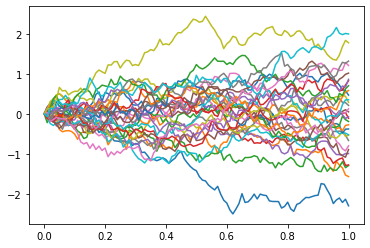

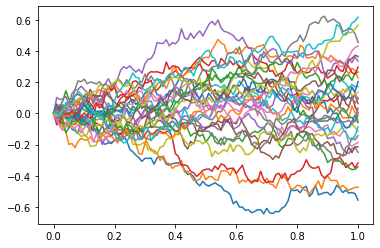

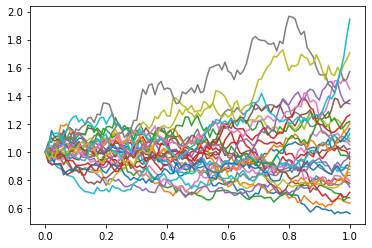

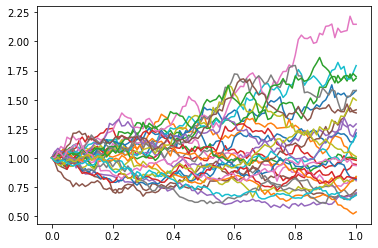

In [8]:
M=100
N=30
draw=True
for i in range(N):
    straBM(M,N,i+1,draw)
    
plt.show()

delta=0.05
sigma=0.3
T=1
for i in range(N):
    straGenBM(M,N,i+1,draw,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    GBM(M,N,draw,S0,delta,sigma,T)
    
plt.show()

In [9]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.45936431028692853 0.004281653346498953
7.552621126174927


In [10]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.4597295162708673 0.004413363437884986
4.24933123588562


**8.9**

In [11]:
g=lambda x: np.sqrt(5/4+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.8275760768295433 0.6296329498291016
1.8273666256796721 0.6244878768920898
0.5518809647333851 0.12729625310685863 4.2999792386093585


In [12]:
g=lambda x: np.sqrt(1+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.6828375478149447 0.4715561866760254
1.682513589898404 0.5529451370239258
0.46779077440067457 0.15181827458721966 3.6130685138956173


**8.10**

In [13]:
df=pd.read_csv('data/ch8.8.10.csv')
roulette=df.values
print(roulette.shape)
num=roulette[:,0]
alpha1=roulette[:,1]+1
alpha2=roulette[:,2]+1

(38, 3)


In [14]:
def roulette(num,alpha,wheel,size):
    def h(x):
        y=np.ones_like(x)*1.0
        for a in alpha[num!=wheel]:
            y*=gamma.cdf(x,a=a)

        return y

    X=gamma.rvs(size=size,a=alpha[num==wheel])
    print('conditional:')
    print(np.mean(h(X)),np.std(h(X))/np.sqrt(size))
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==S.max(axis=1)
    print('normal:')
    print(np.mean(S1),np.std(S1)/np.sqrt(size))
    S2=S[:,num==wheel].flatten()/S.sum(axis=1)
    print('probability:')
    print(np.mean(S2),np.std(S2)/np.sqrt(size))
    print('alpha:')
    print(alpha[num==wheel]/np.sum(alpha))

In [15]:
size=100000
roulette(num,alpha1,19,size)
print()
roulette(num,alpha2,3,size)
print()
roulette(num,alpha1,36,size)

conditional:
0.6306204328589967 0.0010921681780985913
normal:
0.63187 0.0015251567234222192
probability:
0.02862270885672507 1.8598807654015148e-06
alpha:
[0.02862046]

conditional:
0.738163175024325 0.0009160140511142226
normal:
0.73615 0.0013936756347873774
probability:
0.029580174222174984 2.425651277399961e-06
alpha:
[0.02958105]

conditional:
0.10768348975348933 0.0006136841294425467
normal:
0.10577 0.0009725364111435623
probability:
0.02782999893286968 1.8418728254334374e-06
alpha:
[0.02783136]


**8.11**

In [27]:
def roulette(num,alpha,wheel,size):
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==np.sort(S,axis=1)[:,-2]
    print(np.mean(S1),np.std(S1)/np.sqrt(size))

In [28]:
roulette(num,alpha1,19,10000)

0.1723 0.003776409802974249


**8.13**